In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [3]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df = df.iloc[::-1]

In [4]:
# Data Exploration
df.head()
df.tail()
df.shape
df.columns
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 2034 to 0
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [5]:
# Data Preprocessing
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [6]:
# Check for duplicates
duplicates = df.duplicated()
duplicates.value_counts()  # no duplicates present

False    2035
dtype: int64

<Axes: >

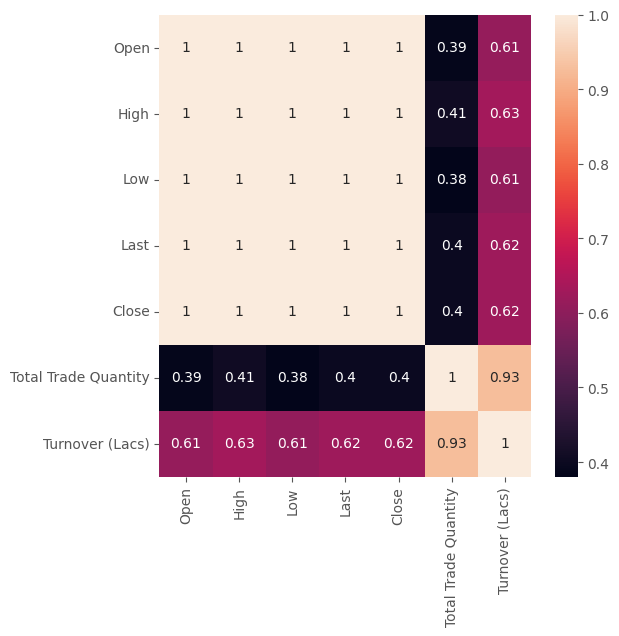

In [7]:
# Correlation heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(), annot=True)

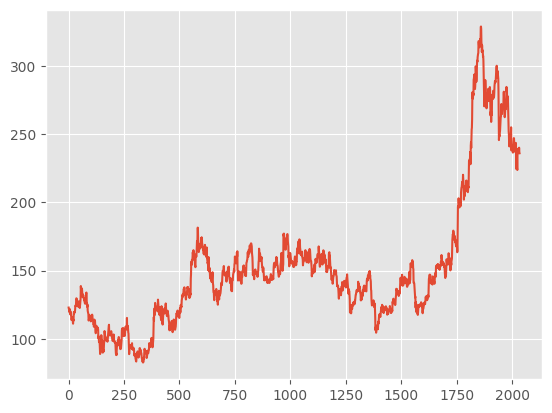

In [8]:
# Plotting the 'High' column
df_high = df.reset_index()['High']
plt.plot(df_high)

In [9]:
# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1, 1))

In [10]:
# Split the data into train and test sets
training_size = int(len(df_high) * 0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size, :], df_high[training_size:len(df_high), :1]
training_size, test_size

(1526, 509)

In [11]:
# Create dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [12]:
# Reshape the input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Model building
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
# Model training
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
23/23 [==============================] - 13s 249ms/step - loss: 0.0109 - val_loss: 0.0264
Epoch 2/50
23/23 [==============================] - 4s 186ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 3/50
23/23 [==============================] - 6s 283ms/step - loss: 9.0927e-04 - val_loss: 0.0034
Epoch 4/50
23/23 [==============================] - 4s 193ms/step - loss: 8.2752e-04 - val_loss: 0.0030
Epoch 5/50
23/23 [==============================] - 5s 200ms/step - loss: 7.8058e-04 - val_loss: 0.0040
Epoch 6/50
23/23 [==============================] - 6s 262ms/step - loss: 7.6384e-04 - val_loss: 0.0035
Epoch 7/50
23/23 [==============================] - 4s 181ms/step - loss: 7.4031e-04 - val_loss: 0.0029
Epoch 8/50
23/23 [==============================] - 4s 184ms/step - loss: 7.0542e-04 - val_loss: 0.0067
Epoch 9/50
23/23 [==============================] - 6s 265ms/step - loss: 7.1241e-04 - val_loss: 0.0033
Epoch 10/50
23/23 [==============================] - 4s 182ms/step - lo

In [14]:
# Model predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

13/13 [==============================] - 1s 40ms/step


In [15]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [16]:
# Calculate RMSE performance metrics
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 137.20281622726762
Test RMSE: 226.38268179419586


In [17]:
# Plotting
look_back = 100

In [18]:
# Shift train prediction for plotting
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

In [19]:
# Shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df_high) - 1, :] = test_predict


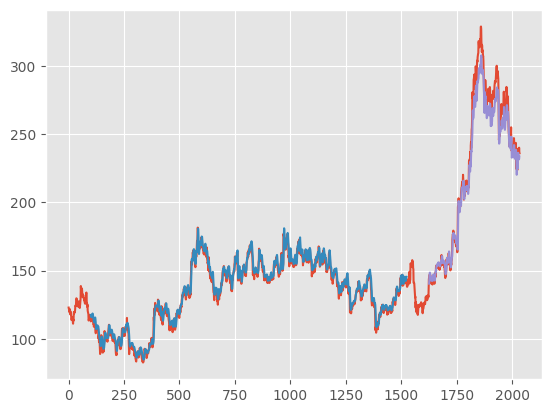

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data


In [21]:
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green indicates the Predicted Data")
print("Blue indicates the Complete Data")
print("Orange indicates the Train Data")

In [22]:
# Predict the next 28 days Stock Price
len(test_data), x_test.shape
x_input = test_data[409:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
nextNumberOfDays = 28
i = 0

while i < nextNumberOfDays:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

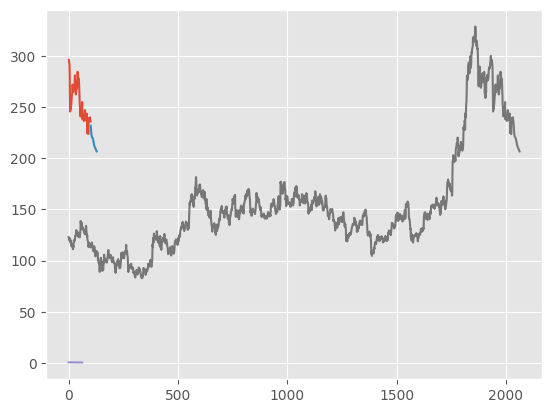

In [23]:
# Plot the predicted values
day_new = np.arange(1, 101)
day_pred = np.arange(101, 129)

plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

data_new = df_high.tolist()
data_new.extend(lst_output)

plt.plot(data_new[2000:])
data_new = scaler.inverse_transform(data_new).tolist()
plt.plot(data_new)